<a href="https://colab.research.google.com/github/krishnakantsingh14/IntegratedOmics/blob/master/kinase_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Omics Analysis for kinase inhibitors on different cell lines

we will perform two types of analysis:
  - Explore Kinase inhibitor drug effects on kinases across 6 different cell lines

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import matplotlib.pyplot as plt
%matplotlib inline 
import fancyimpute as ft
import seaborn as sns
from sklearn.manifold import TSNE
import glob
import codecs

Using TensorFlow backend.


In [13]:
# # file_id= '1oTe98vkX4BHpVpVqSU0fT_j45JWYp26q'
# file_id = '1oTPJ-UjuqLbmHpc5QAdUD1yso8OONR5O'


# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # PyDrive reference:
# # https://googledrive.github.io/PyDrive/docs/build/html/index.html


# from google.colab import auth
# auth.authenticate_user()

# from googleapiclient.discovery import build
# drive_service = build('drive', 'v3')

# # Replace the assignment below with your file ID
# # to download a different file.
# #
# # A file ID looks like: 1gLBqEWEBQDYbKCDigHnUXNTkzl-OslSO

# import io
# from googleapiclient.http import MediaIoBaseDownload

# request = drive_service.files().get_media(fileId=file_id)
# downloaded = io.BytesIO()
# downloader = MediaIoBaseDownload(downloaded, request)
# done = False
# while done is False:
#   # _ is a placeholder for a progress object that we ignore.
#   # (Our file is small, so we skip reporting progress.)
#   _, done = downloader.next_chunk()

# fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
# print(fileId['title'])  
# fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

# # !unzip {fileId['title']}

LINCS_P100_PRM_Plate28_annotated_minimized_2016-04-08_15-41-04.processed.gct


In [0]:
# !pip install fancyimpute

In [0]:
import numpy as np
import numpy.linalg as LA
import matplotlib.mlab as mlab
from sklearn.metrics.pairwise import euclidean_distances
import math

class MultiOmics:


    def __init__(self, datamatrix):
        self.datamatrix      =    datamatrix
        self.epsilon         =    0.0
        self.distancematrix  =    euclidean_distances(self.datamatrix,self.datamatrix) 

    # def getdistancematrix(self):

    #     """ return a square distance matrix. currently support euclidean distance, can be exteneded
    #      to other types of distances """

    #     distancematrix     =     euclidean_distances(self.datamatrix,self.datamatrix)
    #     return distancematrix

    def getepsilon(self, epsilonmin, epsilonmax):
        
        """ Return a list that contain log-log values of epsilon and sum of kernal matrix.
        Maybe lnepsRange[logSumkernelMatrix.index(min(logSumkernelMatrix))] can be used to automatic select the epsilon value, but
        it is a good practive to plot this curve as datamatrix might be very wildly distributed with multiple peaks."""


        #distancematrix          =   self.getdistancematrix(datamatrix)
        logSumkernelMatrix      =   [];
        dellneps                =   0.1
        lnepsrange              =   mlab.frange(epsilonmin, epsilonmax, dellneps)
        for lneps in lnepsrange:

            eps                 =   np.exp(lneps)
            kernalMatrix        =   np.exp(-self.distancematrix ** 2 / (2 * eps))
            logSumkernelMatrix.append(np.log(np.sum(kernalMatrix)))

        #print np.average(logSumkernelMatrix)
        #print (logSumkernelMatrix- np.average(logSumkernelMatrix))

        self.epsilon = np.exp(lnepsrange[ (np.absolute(logSumkernelMatrix- np.average(logSumkernelMatrix))).argmin() ])

        return [lnepsrange, logSumkernelMatrix]


    def diffusionmaps(self, alpha):
        """ Function return eigenvalues and eigenvectors.
        The spectral gap in eigenvalues can be used to determined the intrinsic dimensionality of a given system. """

        
        dimension              =      self.distancematrix.shape[0]
        diagonalMatrix         =      np.zeros((dimension, dimension))
        normalizedKernelMatrix =      np.zeros((dimension, dimension))
        kernalMatrix           =      np.exp(-self.distancematrix ** 2 / (2 * self.epsilon))

        for i in range(0, dimension):
            for j in range(0, dimension):
                normalizedKernelMatrix[i][j]    =          kernalMatrix[i][j] /((math.pow(np.sum(kernalMatrix[i]), alpha)) * (math.pow(np.sum(kernalMatrix[j]), alpha)))
            diagonalMatrix[i][i]                =          np.sum(normalizedKernelMatrix[i])

        #TODO:: use matrix multiplication to combine both for loops
        del kernalMatrix #Memory::free
        
        markovMatrix                =       np.dot(LA.inv(diagonalMatrix), normalizedKernelMatrix)

        # for i in range(0, dimension):
        #     print np.sum(markovMatrix[i])

        eigenvalues, eigenvectors   =       LA.eig(markovMatrix)
        del diagonalMatrix, normalizedKernelMatrix, markovMatrix  #Memory::Free



        eigenvectors = np.transpose(eigenvectors)
        #ev = np.real(ev)
        #ew = np.real(ew)

        return [eigenvalues, eigenvectors]

In [0]:
from sklearn.decomposition import PCA
import Dmomics1 as dm

def t_sneanalysis(data, dimension=2, per=60):
    X = data.values
    t_embedded = TSNE(n_components= dimension, perplexity=per, learning_rate=10).fit_transform(X)
    return t_embedded

def pca_analysis(data, n_components):
    pca= PCA(n_components=n_components)
    return pca.fit_transform(data.values)

In [0]:
lincs_p100 = {}
cell_id = {}
gene_id = {}
pr_modified = {}
data_for_drugs = {}
keys = lincs_p100.keys()

for f in glob.glob('*.gct'):
    a = f.split('_annotated')
    name = str(a[0])
    reading_file =  doc1 = codecs.open(f) #open for reading with "universal" type set
    lincs_p100[name] = pd.read_csv(reading_file, sep='\t', skiprows=2)
    
for f in lincs_p100.keys():
#     print f
    header_index = (lincs_p100[f].index[lincs_p100[f]['id'] =='pert_iname'])[0]
    cell_id[f] = lincs_p100[f].iloc[(lincs_p100[f].index[lincs_p100[f]['id'] =='cell_id'])[0]][-1]
    findingGneIndex = (lincs_p100[f].index[lincs_p100[f]['id'] =='10011_DYRK_Y321_IYQY[+80]IQSR'])[0]
#     gene_id[f] = lincs_p100[f]['pr_gene_symbol'][findingGneIndex:]
    pr_modified[f] = lincs_p100[f]['pr_p100_modified_peptide_code'][findingGneIndex:]
#     print header_index
    j = findingGneIndex
    for i in lincs_p100[f]['pr_p100_modified_peptide_code'].values[findingGneIndex:]:
        gene_id[i] =  lincs_p100[f]['pr_gene_symbol'].values[j]
        j +=1
#     lincs[f][pr_gene_symbol]

    lincs_p100[f].columns = lincs_p100[f].iloc[header_index]
    
for f in keys:
    lincs_p100[f].columns = lincs_p100[f].columns.fillna('to_drop')
    
    #Fill nan to to_prop, in next step drop these columns     
    lincs_p100[f].drop('to_drop', axis = 1, inplace = True)
    rowstoremove       = lincs_p100[f]['pert_iname'].tolist()
    first_header_index = rowstoremove.index('det_well')
    first_header = lincs_p100[f].iloc[first_header_index].tolist()
    remove_rows_until_this_index = rowstoremove.index('10011_DYRK_Y321_IYQY[+80]IQSR')
    lincs_p100[f] = lincs_p100[f][remove_rows_until_this_index:]
#     print (f,remove_rows_until_this_index)

#     i = 0
#     drug = lincs_p100[f].columns[1:][0]
#     header_list = ['Drugs_plate']
#     for col in lincs_p100[f].columns[1:]:

#         if (drug==col):
#             i=i+1
        
#         else:
#             i = 1
#             drug = col
#         header_list.append(col+'_'+str(i))
    tups = zip(first_header,lincs_p100[f].columns)
    lincs_p100[f].columns = lincs_p100[f].columns


### Loading LINCS data for MCF7 Cell lines


- Plate29_03H Kinase Inhibitors MCF7
- Plate29_24H Kinase Inhibitors (24h) MCF7 
- Plate29_06H Kinase Inhibitors (6h) MCF7
- 
- 

In [0]:

from collections import defaultdict 
working_lincs_p100 = {}
cell_id_df_index = defaultdict(list)
for f in keys:
    ll = []

    working_lincs_p100[f] = { cell_id[f] : pr_modified[f]}
    ll.append(cell_id[f])
    cell_id_df_index[cell_id[f]].append(f)
#     print (np.array(lincs_p100[f]).shape)
    for col in (lincs_p100[f].columns).unique()[1:]:
#         print (len(lincs_p100[f][col].as_matrix().shape), f)
        if (len(lincs_p100[f][col].values.shape) > 1):
            _replicatesValue = pd.to_numeric(lincs_p100[f][col].values[:,0])
            numberofreplicas = lincs_p100[f][col].shape[1]
            for i in range(1,numberofreplicas):
                _replicatesValue = np.vstack((np.array(_replicatesValue), 
                                              pd.to_numeric(lincs_p100[f][col].values[:,i])))
#         print _replicatesValue.T.shape

            _replicatesValue = _replicatesValue.T
            average_replicate = np.average(_replicatesValue,axis=1)
        else:
            _replicatesValue = pd.to_numeric(lincs_p100[f][col].values)
             
        ll.append(col)
#         print average_replicate
        working_lincs_p100[f][str(col)] = average_replicate
     
    new = pd.DataFrame.from_dict(working_lincs_p100[f])
    columnsTitles = ll
    new=new.reindex(columns=columnsTitles)
    working_lincs_p100[f] = new

#         working_lincs_p100[f] = [cell_id[f]
                                       
#         working_lincs_p100[f] = [cell_id[f]:lincs_p100[f].columns[0]]
        
#         #Convert strings to numerical value
# #         print f, col
#         for i in :
#             lincs_p100[f][col] = pd.to_numeric(lincs_p100[f][col].as_matrix())


Integrating kinease inhibitors

    Plate32 Kinase Inhibitors YAPC
    Plate34 Kinase Inhibitors PC3
    Plate27 Kinase Inhibitors NPC
    Plate29_03H Kinase Inhibitors MCF7
    Plate33 Kinase Inhibitors A549
    Plate28 Kinase Inhibitors A375
    Plate29_24H Kinase Inhibitors (24h) MCF7 
    Plate29_06H Kinase Inhibitors (6h) MCF7 
    

We are *not considering* 
**'LINCS_P100_PRM_Plate29_06H' 'LINCS_P100_PRM_Plate29_24H'** plates for MFC7 Cell-lines

In [0]:

kinase_lics = ['LINCS_P100_DIA_Plate27',
'LINCS_P100_PRM_Plate28',
'LINCS_P100_PRM_Plate29_03H',
'LINCS_P100_PRM_Plate32',
'LINCS_P100_DIA_Plate33',
'LINCS_P100_DIA_Plate34'
]



In [25]:
cell_id['LINCS_P100_DIA_Plate27']

'NPC'

### Adding cell is names with proteins (will be useful to identify protein from which cell lines)

aaaaa -> aaaa_NPC
** We are working with 6 cell lines **  
1 NPC  
2 A375  
3 MCF7  
4 YAPC  
5 A549  
6 PC3 

In [27]:
kinase_concat_lincs = working_lincs_p100[kinase_lics[0]].set_index(working_lincs_p100[kinase_lics[0]].columns[0])
kinase_concat_lincs = kinase_concat_lincs.set_index(kinase_concat_lincs.index.astype(str)+ str('_'+cell_id[kinase_lics[0]]))

for i in range(1,len(kinase_lics)):
    print (i, working_lincs_p100[kinase_lics[i]].columns[0])
    _ = working_lincs_p100[kinase_lics[i]].set_index(working_lincs_p100[kinase_lics[i]].columns[0])
    _ = _.set_index(_.index.astype(str) +str ('_'+ cell_id[kinase_lics[i]]))
    kinase_concat_lincs = pd.concat([kinase_concat_lincs, _])

1 A375
2 MCF7
3 YAPC
4 A549
5 PC3


In [28]:
kinase_concat_lincs

,DMSO,flavopiridol,CC-401,Pazopanib,Selumetinib,PD-0332991,SCH 900776,Nilotinib,PD0325901,Dinaciclib,...,dactolisib,IPI145,Tofacitinib,SP600125,afuresertib,staurosporine,Pravastatin,vorinostat,BYL719,PS-1145
IYQY[+80]IQSR_NPC,-0.019111,0.067164,-0.075369,0.270228,-0.289719,0.117993,-0.083802,0.138025,-0.063086,0.258752,...,-0.098822,-0.024247,-0.079818,0.113169,0.250750,0.359376,-0.163839,-0.168338,0.067212,0.037752
TPKDS[+80]PGIPPSANAHQLFR_NPC,-0.321789,-0.740104,0.002915,1.403989,1.419831,-0.005058,0.126698,0.095904,1.506496,-0.298970,...,0.065716,0.171048,-0.300836,0.545009,NaN,2.303235,-0.079442,-0.419472,NaN,0.135255
RNS[+80]SEASSGDFLDLK_NPC,0.016651,0.185323,0.281689,0.217865,0.409194,0.292825,0.009019,-0.026009,0.032783,0.105422,...,-0.164875,-0.283713,-0.070025,-0.147616,NaN,0.241553,0.007737,0.217503,-0.289120,-0.195440
LPLVPES[+80]PRR_NPC,-0.350689,0.105957,0.080687,-0.072312,0.103718,0.249198,0.069509,-0.063781,-0.298971,-0.127221,...,-0.050622,0.081913,-0.071271,-0.178510,-0.483576,-1.421853,-0.145502,-0.113612,0.253167,0.110038
ANAS[+80]PQKPLDLK_NPC,-0.020958,0.077784,0.248626,0.140105,-0.066004,-0.123369,-0.028936,0.000888,0.096019,-1.292621,...,-0.186858,0.105658,-0.067804,0.127292,0.235807,-0.331835,-0.031517,-0.047442,-0.015651,-0.028860
LENS[+80]PLGEALR_NPC,-0.065330,-0.932782,-0.213509,0.265962,0.120341,-0.081923,-0.234600,-0.644745,-0.483630,NaN,...,0.417616,0.145832,-0.112541,-0.854479,NaN,-0.185073,0.285640,-0.165148,0.020424,0.274602
ANS[+80]FVGTAQYVSPELLTEK_NPC,0.073164,0.122094,0.100569,0.186310,-0.131303,-0.102165,-0.095383,-0.076877,-0.061284,0.302510,...,-0.068996,0.041203,0.026284,0.121961,0.272040,0.143275,0.064869,0.028673,-0.100101,-0.025920
TNPPTQKPPS[+80]PPMSGR_NPC,-0.122715,0.015112,0.078884,NaN,-0.174149,-0.044600,-0.002965,NaN,-0.030653,0.264733,...,-0.037808,0.147428,NaN,0.041998,0.344719,0.594245,-0.153996,-0.161802,-0.002378,-0.147264
SNS[+80]LPHSAVSNAGSK_NPC,0.055947,0.121190,0.250047,-0.373933,0.380417,0.052633,0.220416,-0.155282,0.322059,0.522756,...,-0.313844,-0.190712,0.075312,0.147518,0.007220,0.052769,-0.060933,0.069705,-0.394357,-0.097919
VGS[+80]LDNVGHLPAGGAVK_NPC,-0.131711,0.549983,0.391367,0.494004,-0.171090,0.183854,-0.189858,-0.027716,-0.239885,0.658188,...,0.219423,0.101182,-0.212672,-0.342582,-0.194664,-3.158401,-0.115115,-0.002140,0.149440,0.012259


#### Missing values

Check if concatenated data contain any missing value

In [30]:
print (pd.isnull(kinase_concat_lincs).values.any())


True


In [31]:
# Filling missing values with KNN algorithms
_tmpDf = kinase_concat_lincs
integrated_kinase = pd.DataFrame(ft.KNN(3).fit_transform(_tmpDf.values),
                             index = _tmpDf.index, 
                             columns=_tmpDf.columns) 

Imputing row 1/498 with 0 missing, elapsed time: 0.063
Imputing row 101/498 with 0 missing, elapsed time: 0.065
Imputing row 201/498 with 0 missing, elapsed time: 0.066
Imputing row 301/498 with 1 missing, elapsed time: 0.067
Imputing row 401/498 with 6 missing, elapsed time: 0.068


In [32]:
print (pd.isnull(integrated_kinase).values.any())


False


# Analysis

## Correlation analysis

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


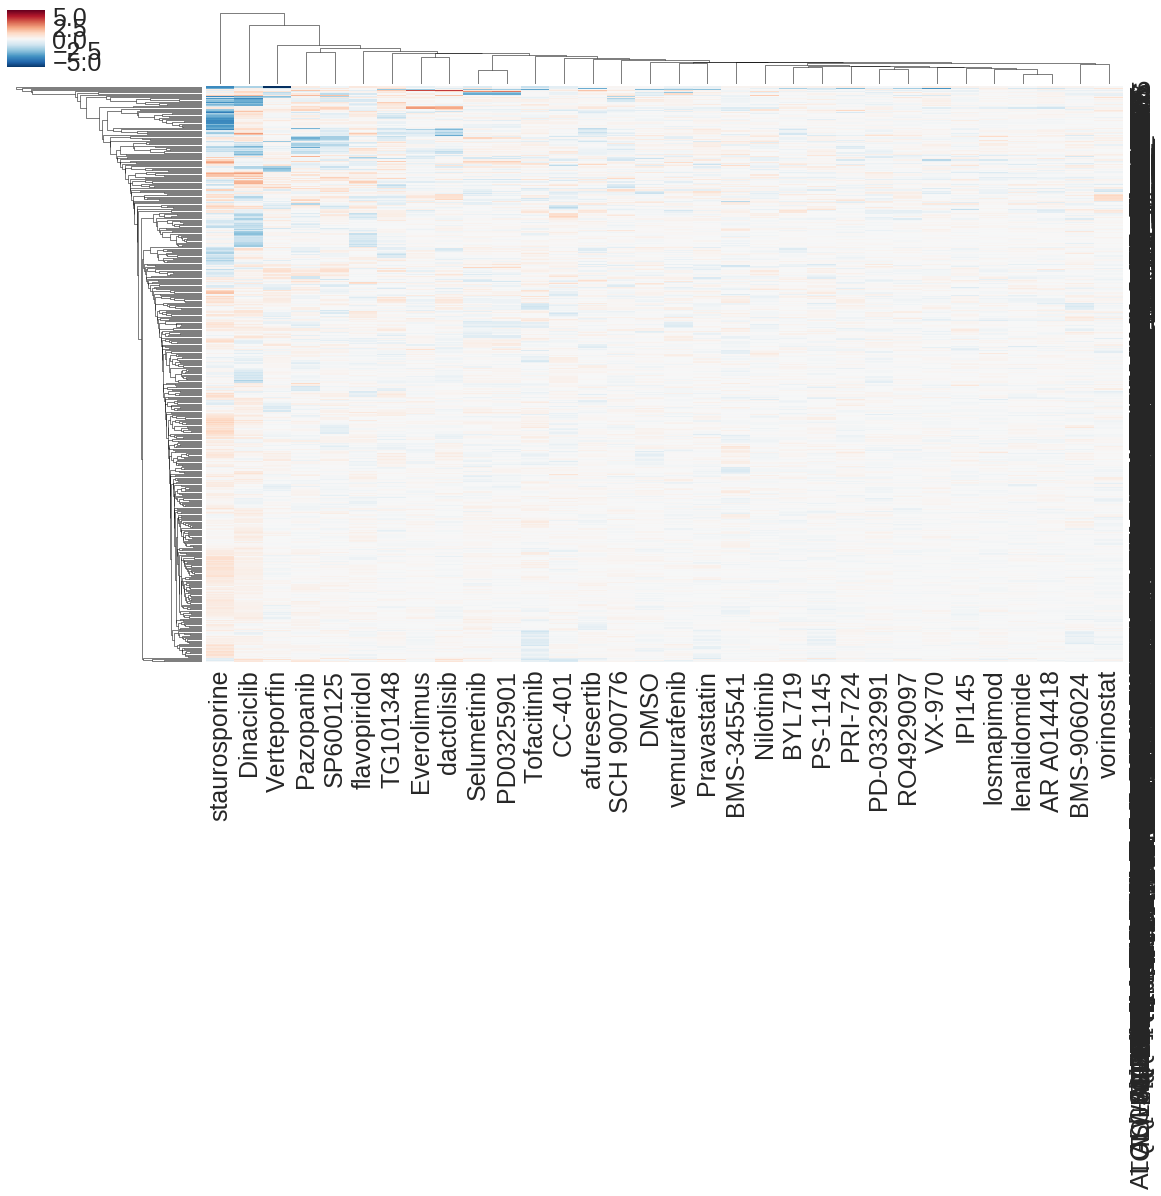

In [36]:
# sns.set(font_scale=2.5)
sns.clustermap(integrated_kinase, cmap='RdBu_r', figsize = (20,12))

### using euclidean distance: 
 - staurosporine
 - Dinaciclib
 - Verteporfin  
 
------------------------------------
BMS 
Vorinostat

 drugs showing diverse effects
 
 (will come to proteins later)
 
Let's find if similar things can be found using **correlation matrix**

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


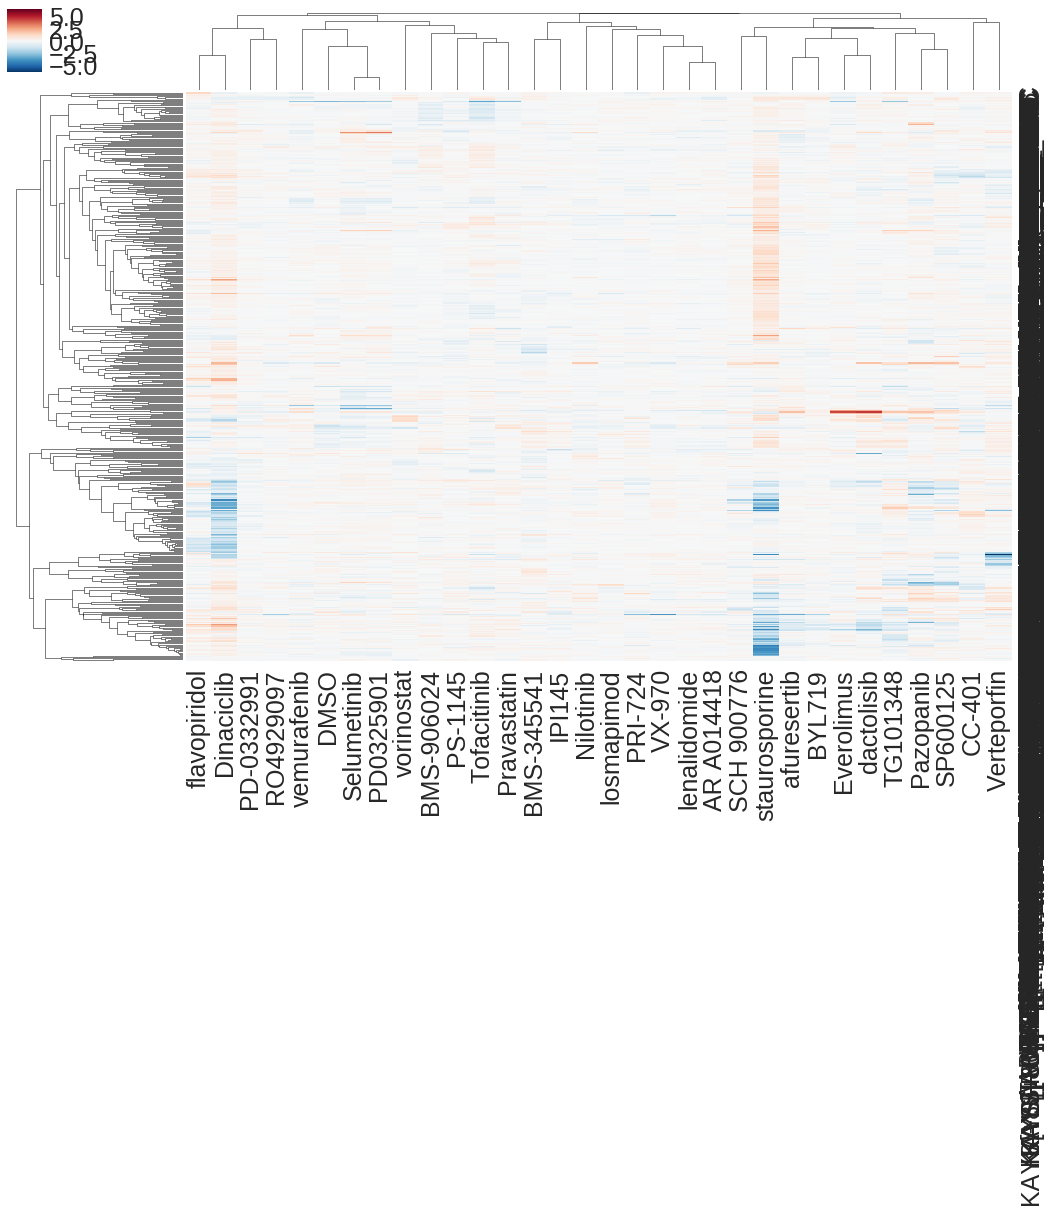

In [38]:
sns.set(font_scale=2.5)
sns.clustermap(integrated_kinase, cmap='RdBu_r', figsize = (18,12), metric="correlation")

**It is hard to conclude something from this**
-  staurosporine and SCH are in same cluster (we need to dinf correlation between them and explain why?)

Similar to this Dinaciclib and flavopiridol are in same cluster  
*Interestingly*: Verteporfin and CC_401 are in same cluster that is different than rest of drugs



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


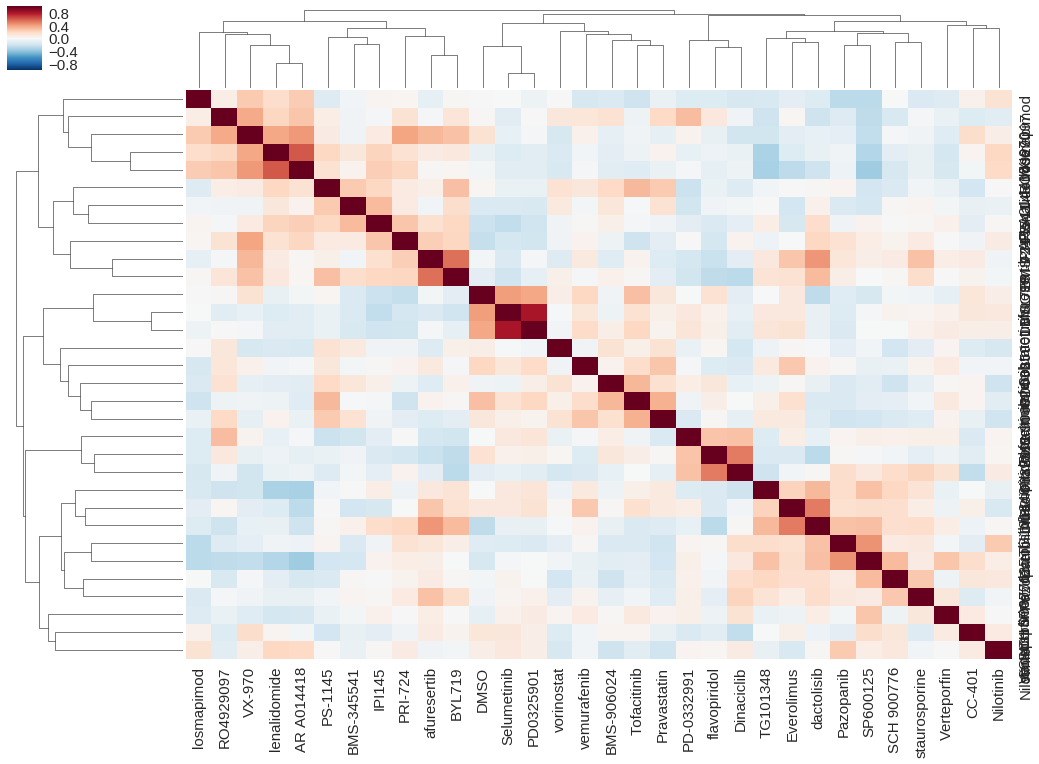

In [44]:
sns.set(font_scale=1.5)

sns.clustermap(integrated_kinase.corr(), cmap='RdBu_r', figsize = (18,12))

** Nilotinib ** showing some correlation with CC-401

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


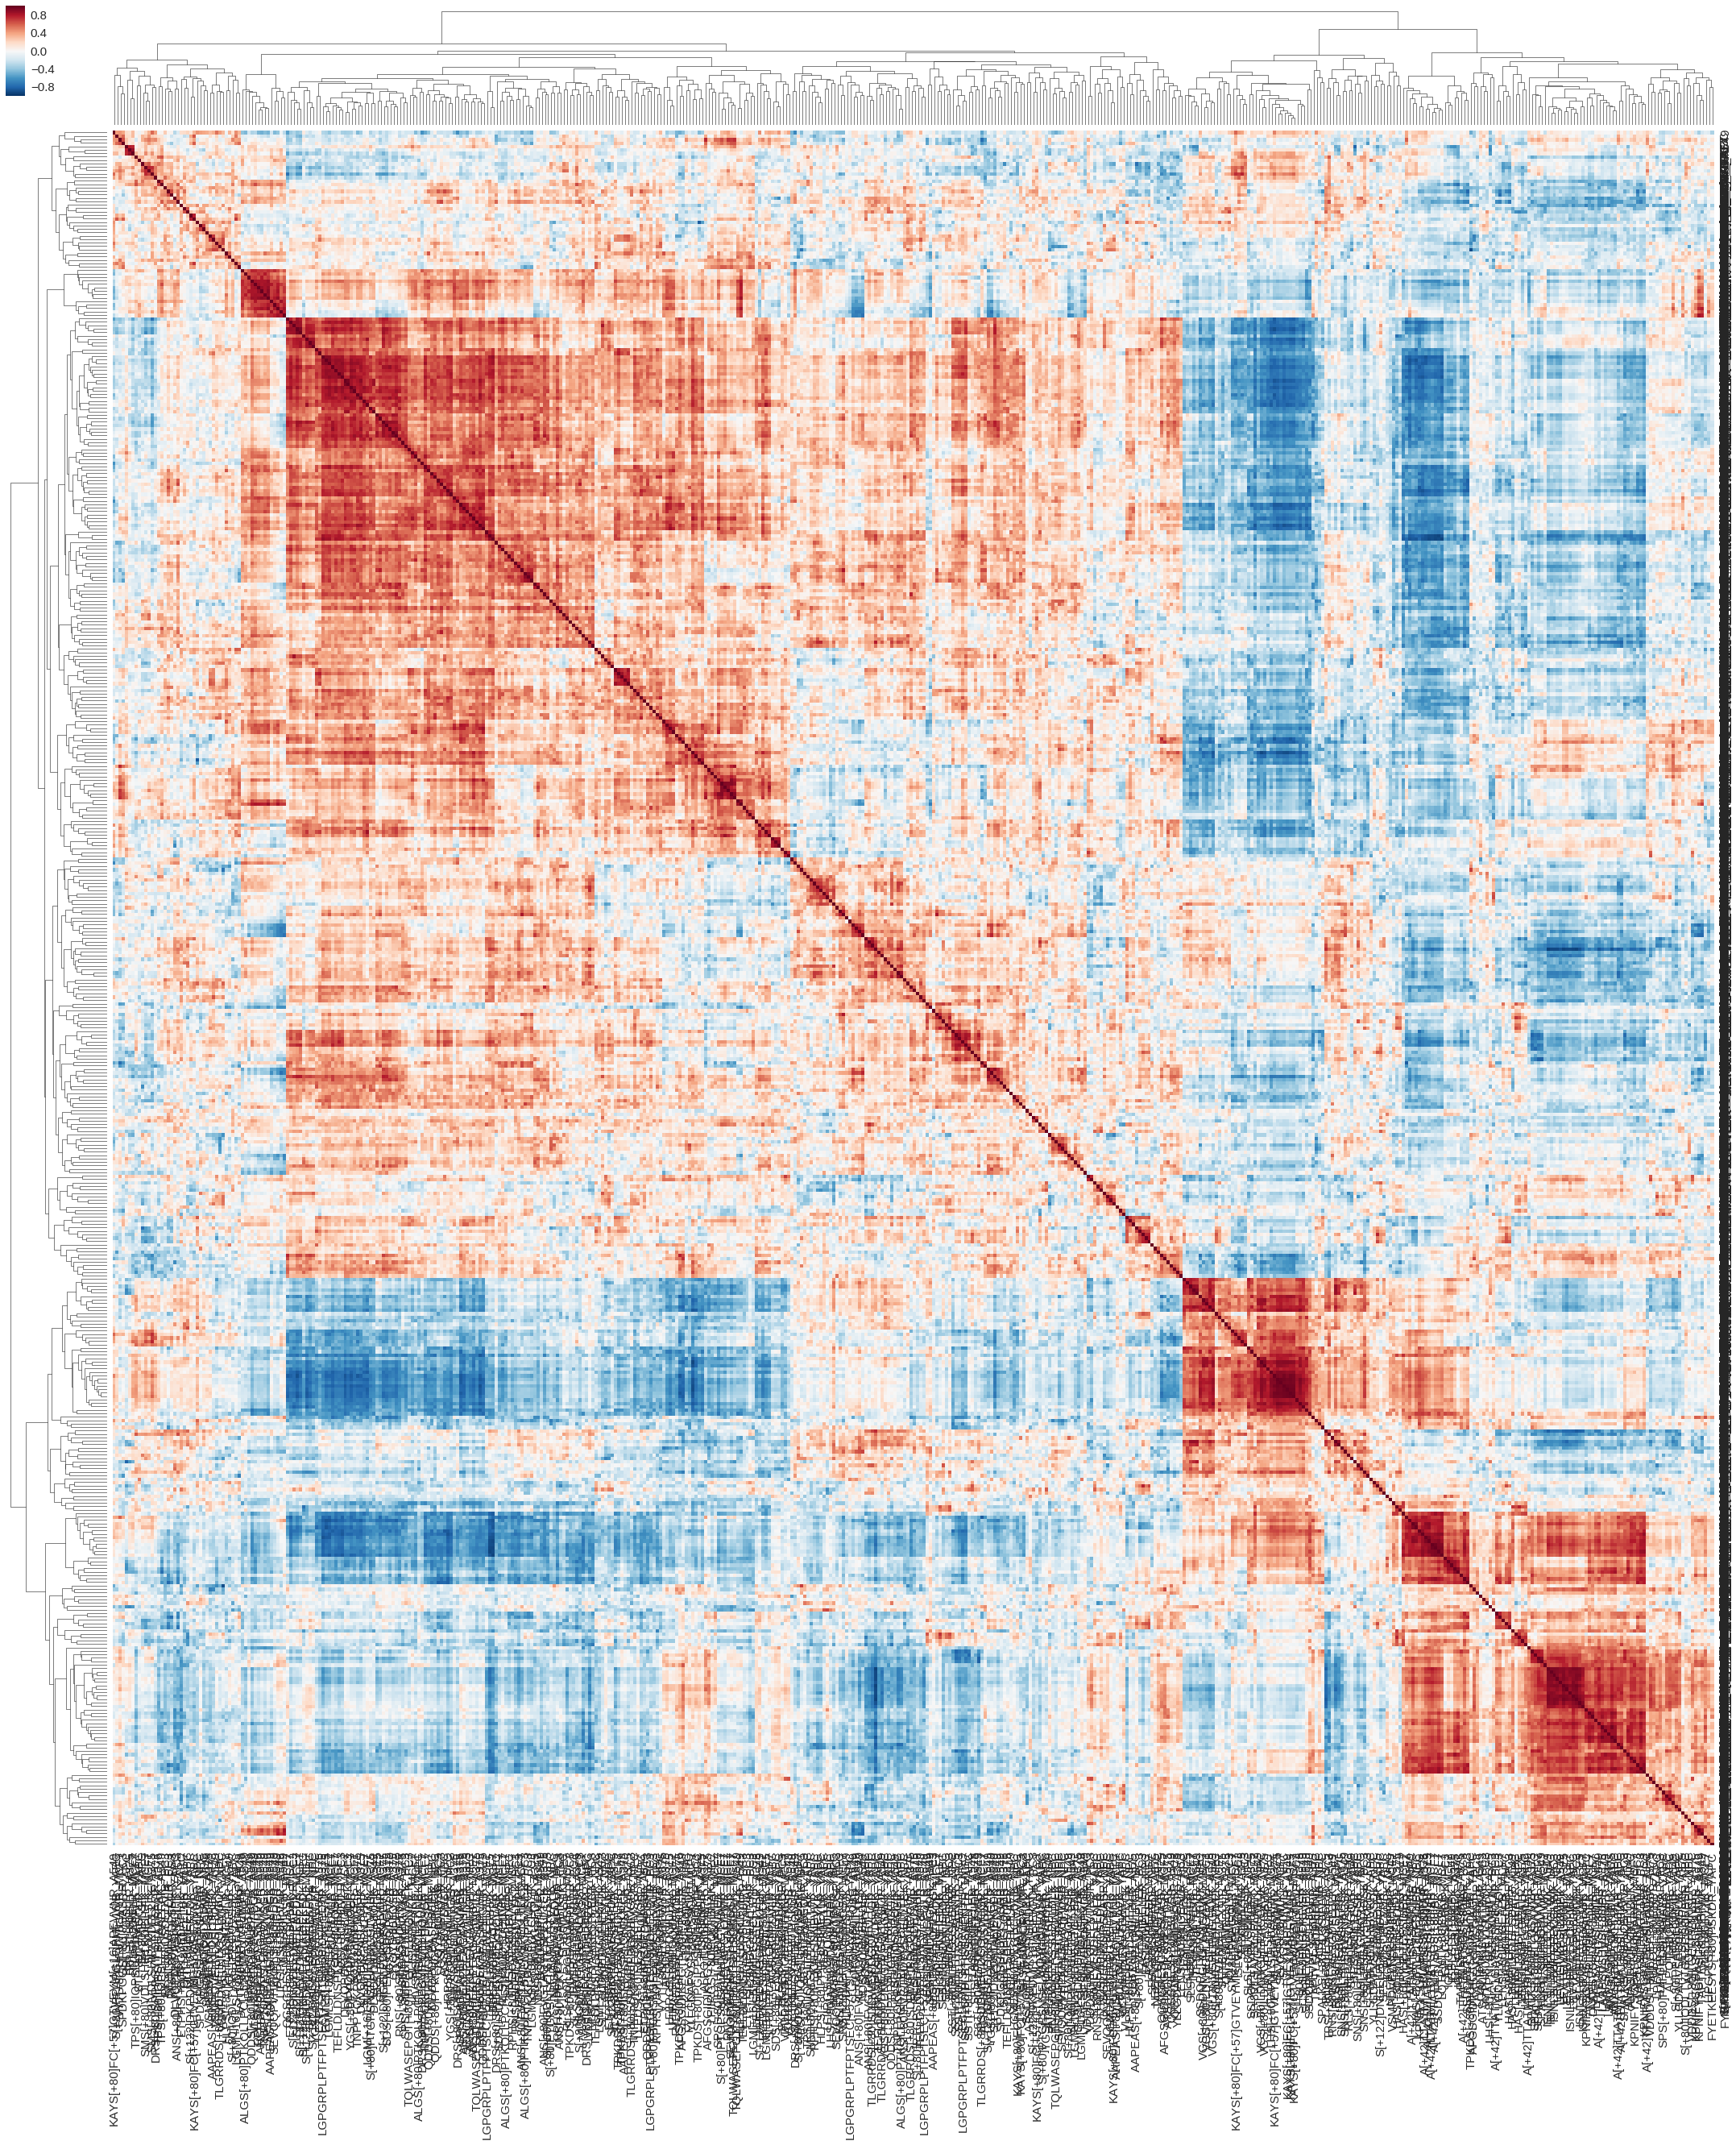

In [45]:
sns.clustermap(integrated_kinase.T.corr(), cmap='RdBu_r', figsize = (38,42))

TODO:: We will come to this later

# Now we will do Diffusion maps analysis,

In the best case,  
-  Different Proteins/Kinases should form different clusters
-  Each drug have a cluster 
-  **Cell lines**: No comment


In [0]:

df = integrated_kinase.values
k_dm = dm.MultiOmics(datamatrix=df)
ln1, ln2 = k_dm.getepsilon(epsilonmax=10,epsilonmin=-10)

In [0]:
Eval, Evec = k_dm.diffusionmaps(alpha=1) 
idx = np.argsort(-Eval)
Eval = Eval[idx]
v = Evec[:,idx]

Text(0,0.5,'Eigen values')

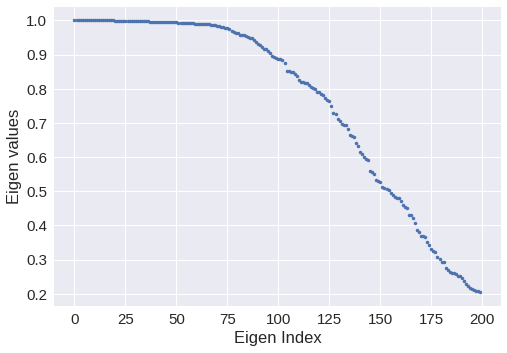

In [50]:
plt.plot(Eval[:200], ".")
plt.xlabel('Eigen Index')
plt.ylabel('Eigen values')

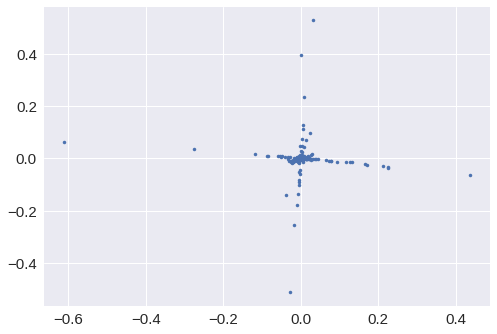

In [51]:
plt.plot(v[1], v[2], ".");

## There are plenty of single point cluster, it is better to use t-sne for visualization

**Create low dimensional representation: **

From wikipedia: https://en.wikipedia.org/wiki/Diffusion_map

Diffusion process and low-dimensional embedding
The diffusion distance can be calculated using the eigenvectors by

${ D_{t}(x_{i},x_{j})^{2}=\sum _{l}\lambda _{l}^{2t}(\psi _{l}(x_{i})-\psi _{l}(x_{j}))^{2}\,} D_{t}(x_{i},x_{j})^{2}=\sum _{l}\lambda _{l}^{{2t}}(\psi _{l}(x_{i})-\psi _{l}(x_{j}))^{2} $  
So the eigenvectors can be used as a new set of coordinates for the data. 

The diffusion map is defined as:

$ \Psi _{t}(x)=(\lambda _{1}^{t}\psi _{1}(x),\lambda _{2}^{t}\psi _{2}(x),\ldots ,\lambda _{k}^{t}\psi _{k}(x)) \Psi _{t}(x)=(\lambda _{1}^{t}\psi _{1}(x),\lambda _{2}^{t}\psi _{2}(x),\ldots ,\lambda _{k}^{t}\psi _{k}(x)) $

It is proved that

$ D_{t}(x_{i},x_{j})^{2}=||\Psi _{t}(x_{i})-\Psi _{t}(x_{j})||^{2}\, D_{t}(x_{i},x_{j})^{2}=||\Psi _{t}(x_{i})-\Psi _{t}(x_{j})||^{2}\, $
so the Euclidean distance in the diffusion coordinates approximates the diffusion distance

In [0]:
low_dimensional = np.matmul( np.diag(Eval[:100]),v[:100,])

**plotting using t-sne**

In [0]:
t_sne_drug = t_sneanalysis(pd.DataFrame(low_dimensional.T), dimension= 2, per= 50)


1 NPC 
 2 A375 
 3 MCF7 
 4 YAPC 
 5 A549 
 6 PC3


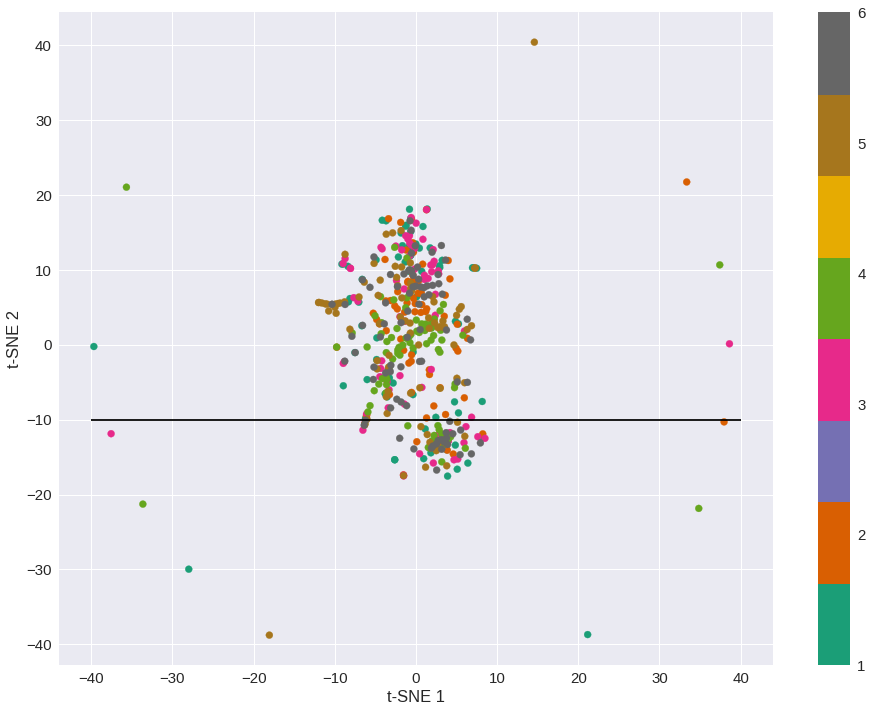

In [75]:
plt.rcParams['figure.figsize'] = (16,12)
c = np.ones(498)
c[83:83*2] = c[83:83*2]*2
c[83*2:83*3] = c[83*2:83*3]*3
c[83*3:83*4] = c[83*3:83*4]*4
c[83*4:83*5] = c[83*4:83*5]*5
c[83*5:83*6] = c[83*5:83*6]*6
plt.scatter(t_sne_drug[:,1], t_sne_drug[:,0], c=c, cmap='Dark2')
plt.hlines(-10, xmin=-40, xmax=40)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar()
print ('1 NPC \n 2 A375 \n 3 MCF7 \n 4 YAPC \n 5 A549 \n 6 PC3')

### Need to check: All single point clusters (check for these kinase-proteins)
### with-in big cluster there are two clusters, try find pattern between these two clusters

/content/sample_data/lincs_data/P1000


['LINCS_P100_PRM_Plate29_06H',
 'LINCS_P100_PRM_Plate29_24H',
 'LINCS_P100_DIA_Plate23',
 'LINCS_P100_DIA_Plate60',
 'LINCS_P100_PRM_Plate29_03H']